In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import numpy as np
import pandas as pd
import modules
import matplotlib.pyplot as plt

from sklearn.metrics import *
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

np.random.seed(0)
torch.manual_seed(0)

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results"

model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
unique_peptides = metadata["peptide"].unique()

In [3]:
validation_pep = "KTWGQYWQV"
unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == validation_pep))

no_pos_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
for pep in no_pos_peptides:
    unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == pep))

threshold = 0.1
cv_fold = 5
excluded = [] # ["KLQCVDLHV", "KVAELVHFL", "YLLEMLWRL", "SLLMWITQV"]

In [4]:
overall_LOO_results_df = pd.DataFrame(columns=[
    "Model", 
    "AUC",
    f"MCC (threshold = {threshold})",
])

individual_AUC_results_df = pd.DataFrame(columns=["Model"] + list(unique_peptides))

individual_MCC_results_df = pd.DataFrame(columns=["Model"] + list(unique_peptides))

overall_CV_results_df = pd.DataFrame(columns=[
    "Model", 
    "AUC",
    f"MCC (threshold = {threshold})",
])

In [5]:
def compute_auc_mcc(pred_paths, threshold):
    overall_pred = list()
    overall_true = list()
    overall_thres_pred = list()
    individual_auc = list()
    individual_mcc = list()

    for i in range(len(pred_paths)):
        data = torch.load(pred_paths[i])
        pred = data["y_pred"]
        true = data["y_true"]

        try:
            auc = roc_auc_score(true, pred)
            individual_auc.append(auc)
            fpr, tpr, _ = roc_curve(true, pred)

            thresh_pred = torch.zeros(len(pred))
            thresh_pred[pred >= threshold] = 1
            mcc = matthews_corrcoef(true, thresh_pred)
            individual_mcc.append(mcc)

            overall_pred.extend(pred)
            overall_true.extend(true)
            overall_thres_pred.extend(thresh_pred)
        except ValueError:
            print(f"Fail for idx {i}")
            individual_auc.append(None)
            individual_mcc.append(None)
        
    overall_auc = roc_auc_score(overall_true, overall_pred)
    overall_fpr, overall_tpr, _ = roc_curve(true, pred, pos_label=1)
    overall_mcc = matthews_corrcoef(overall_true, overall_thres_pred)
    
    return overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc

def plot_roc_curve(unique_peptide, excluded, tpr, fpr, individual_auc):
    # ROC plot
    cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
    for i, pep in enumerate(unique_peptides):
        if pep not in excluded:
            ax.plot(
                fpr[i], 
                tpr[i], 
                label=f"{pep}, AUC = {round(individual_auc[i], 3)}",
            )
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("LOO validation ROC curve")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
    plt.show()

### Embedding verification

In [ ]:
save_dir = Path(out_dir / "b3edafc0112356cefbdde3ca0ec5b396/lstm_embedding_verification")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_pred = list()
overall_true = list()
for i in range(len(pred_paths)):
    data = torch.load(pred_paths[i], map_location="cpu")
    pred = data["y_pred"]
    true = data["y_true"]

    auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
    print(auc)
    overall_pred.extend(pred)
    overall_true.extend(true)
overall_auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
print(overall_auc)

### LOO validation

In [6]:
model_names = [
    "Single LSTM PS",
    "Single LSTM PS (swapped negatives)",
    "Single LSTM energy terms",
    "Quad LSTM PS",
    "Quad LSTM PS (swapped negatives)",
    "Quad LSTM PS+ESM",
    "Quad LSTM ESM",
    "Quad LSTM PS (FoldX)",
    "Quad LSTM PS+ESM (FoldX)",
    "Quad LSTM PS (Rosetta)",
    "Quad LSTM PS+ESM (Rosetta)",
    "CDR3+peptide LSTM PS",
    "CDR3+peptide LSTM PS (swapped negatives)",
    "Modified ProteinSolver",
    "Modified ProteinSolver (FoldX)",
    "Modified ProteinSolver (Rosetta)"
    
    
]

paths = [
    "lstm_ps_single",
    "lstm_ps_single_swapped",
    "lstm_single_energy",
    "lstm_ps",
    "lstm_ps_swapped",
    "lstm_esm_ps",
    "lstm_esm",
    "lstm_ps_foldx",
    "lstm_esm_ps_foldx",
    "lstm_ps_rosetta",
    "lstm_esm_ps_rosetta",
    "lstm_ps_cdr_pep_only",
    "lstm_ps_cdr_pep_only_swapped",
    "proteinsolver_finetune",
    "proteinsolver_finetune_foldx",
    "proteinsolver_finetune_rosetta"
    
]
for model_name, path in zip(model_names, paths):
    print(model_name, path)
    try:
        save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
        pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
        overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
        overall_row = [model_name, overall_auc, overall_mcc]
        overall_LOO_results_df = overall_LOO_results_df.append(
            pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
        )
        individual_AUC_results_df = individual_AUC_results_df.append(
            pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
        )
        individual_MCC_results_df = individual_MCC_results_df.append(
            pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
        )
    except:
        print(model_name, "failed!")

Single LSTM PS lstm_ps_single


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Single LSTM PS failed!
Single LSTM PS (swapped negatives) lstm_ps_single_swapped
Single LSTM PS (swapped negatives) failed!
Single LSTM energy terms lstm_single_energy
Fail for idx 0
Fail for idx 1
Fail for idx 2
Fail for idx 3
Fail for idx 4
Fail for idx 5
Fail for idx 6
Fail for idx 7
Fail for idx 8
Fail for idx 9
Fail for idx 10
Fail for idx 11
Fail for idx 12
Fail for idx 13
Fail for idx 14
Single LSTM energy terms failed!
Quad LSTM PS lstm_ps
Quad LSTM PS failed!
Quad LSTM PS (swapped negatives) lstm_ps_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS (swapped negatives) failed!
Quad LSTM PS+ESM lstm_esm_ps


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS+ESM failed!
Quad LSTM ESM lstm_esm


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM ESM failed!
Quad LSTM PS (FoldX) lstm_ps_foldx
Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS (FoldX) failed!
Quad LSTM PS+ESM (FoldX) lstm_esm_ps_foldx
Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS+ESM (FoldX) failed!
Quad LSTM PS (Rosetta) lstm_ps_rosetta
Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS (Rosetta) failed!
Quad LSTM PS+ESM (Rosetta) lstm_esm_ps_rosetta
Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS+ESM (Rosetta) failed!
CDR3+peptide LSTM PS lstm_ps_cdr_pep_only


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


CDR3+peptide LSTM PS failed!
CDR3+peptide LSTM PS (swapped negatives) lstm_ps_cdr_pep_only_swapped
CDR3+peptide LSTM PS (swapped negatives) failed!
Modified ProteinSolver proteinsolver_finetune


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Modified ProteinSolver failed!
Modified ProteinSolver (FoldX) proteinsolver_finetune_foldx
Fail for idx 13
Fail for idx 14
Modified ProteinSolver (FoldX) failed!
Modified ProteinSolver (Rosetta) proteinsolver_finetune_rosetta
Modified ProteinSolver (Rosetta) failed!


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [7]:
overall_LOO_results_df

,Model,AUC,MCC (threshold = 0.1)
0,Single LSTM PS,0.422768,-0.112476
1,Single LSTM PS (swapped negatives),0.581993,0.111589
2,Quad LSTM PS,0.385946,-0.177863
3,Quad LSTM PS (swapped negatives),0.601471,0.139841
4,Quad LSTM PS+ESM,0.538407,0.057611
5,Quad LSTM ESM,0.448322,0.018213
6,Quad LSTM PS (FoldX),0.509681,-0.051362
7,Quad LSTM PS+ESM (FoldX),0.459599,0.023776
8,Quad LSTM PS (Rosetta),0.557098,0.090968
9,Quad LSTM PS+ESM (Rosetta),0.437909,-0.051747


In [ ]:
individual_AUC_results_df

In [ ]:
import matplotlib.pyplot as plt
save_dir = Path(out_dir / "lstm_ps_single_swapped/b3edafc0112356cefbdde3ca0ec5b396")
#pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(save_dir/"loss_3.pt")
plt.plot(t["train"])
plt.plot(t["valid"])

,Model,NLVPMVATV,SLFNTVATL,RTLNAWVKV,KVLEYVIKV,YLLEMLWRL,IMDQVPFSV,MLDLQPETT,FLYALALLL,SLLMWITQV,LLFGYPVYV,GLCTLVAML,RMFPNAPYL,GILGFVFTL,KLQCVDLHV,KVAELVHFL
0,Single LSTM PS,0.538196,0.604082,0.527184,0.231481,0.565657,0.546296,0.488636,0.481366,0.682353,0.457867,0.619376,0.495726,0.398939,0.75,0.0
1,LSTM PS,0.638329,0.424490,0.614082,0.324074,0.585859,0.435185,0.389205,0.709317,0.576471,0.439467,0.557062,0.490028,0.330291,0.75,0.0
2,LSTM PS+ESM,0.596884,0.114286,0.600267,0.601852,0.515152,0.604167,0.497159,0.545963,0.611765,0.422400,0.553701,0.606838,0.533675,1.0,0.0
3,LSTM ESM,0.654250,0.461224,0.455882,0.194444,0.545455,0.476852,0.446023,0.629814,0.623529,0.474133,0.492541,0.410256,0.395619,1.0,0.5
4,ProteinSolver (BC),0.451634,0.481633,0.459002,0.212963,0.565657,0.645833,0.485795,0.433230,0.741176,0.529867,0.621999,0.378917,0.449635,0.0,1.0
5,LSTM PS FoldX,0.635444,0.471429,0.383459,0.320513,0.564103,0.490260,0.500000,0.600000,0.541667,0.346939,0.527837,0.437500,0.543703,None,None
6,LSTM PS+ESM FoldX,0.677006,0.466667,0.555764,0.525641,0.487179,0.551948,0.492063,0.648684,0.500000,0.425788,0.409091,0.379464,0.467714,None,None
7,ProteinSolver FoldX (BC),0.531532,0.595238,0.533835,0.166667,0.589744,0.538961,0.706349,0.497368,0.541667,0.455009,0.620302,0.392857,0.415524,None,None
8,LSTM PS Rosetta,0.655091,0.347619,0.645990,0.423077,0.512821,0.535714,0.539683,0.397807,0.416667,0.457792,0.447284,0.625000,0.590180,None,None
9,LSTM PS+ESM Rosetta,0.609216,0.295238,0.480576,0.243590,0.589744,0.594156,0.464286,0.539474,0.666667,0.366419,0.403868,0.459821,0.437818,None,None


### 5 fold CV

In [24]:
model_title = "LSTM PS"

save_dir = Path(out_dir / "lstm_ps_80_cv/b3edafc0112356cefbdde3ca0ec5b396")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_CV_results_df = overall_CV_results_df.append(
    pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
)


In [25]:
model_title = "LSTM PS+ESM"

save_dir = Path(out_dir / "lstm_esm_ps_80_cv/b3edafc0112356cefbdde3ca0ec5b396")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_CV_results_df = overall_CV_results_df.append(
    pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
)

In [26]:
model_title = "LSTM ESM"

save_dir = Path(out_dir / "lstm_esm_80_cv/b3edafc0112356cefbdde3ca0ec5b396")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_CV_results_df = overall_CV_results_df.append(
    pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
)

In [34]:
model_title = "ProteinSolver"

save_dir = Path(out_dir / "proteinsolver_finetune_80_cv/b3edafc0112356cefbdde3ca0ec5b396")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_CV_results_df = overall_CV_results_df.append(
    pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
)

EOFError: Ran out of input

In [35]:
model_title = "Single LSTM energy terms"

save_dir = Path(out_dir / "lstm_single_energy_80_cv/b3edafc0112356cefbdde3ca0ec5b396")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_CV_results_df = overall_CV_results_df.append(
    pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
)

Fail for idx 0
Fail for idx 1
Fail for idx 2
Fail for idx 3
Fail for idx 4


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [67]:
for i in torch.load(pred_paths[4])["y_true"]:
    if i > 0:
        print(i)

In [36]:
overall_CV_results_df

,Model,AUC,MCC (threshold = 0.1)
0,LSTM PS,0.870819,0.450423
1,LSTM PS,0.870819,0.450423
2,LSTM PS+ESM,0.878844,0.480504
3,LSTM ESM,0.881669,0.429481


In [18]:
data = torch.load(pred_paths[4])
pred = data["y_pred"]
true = data["y_true"]
roc_auc_score(true, pred)



0.5426050841389187

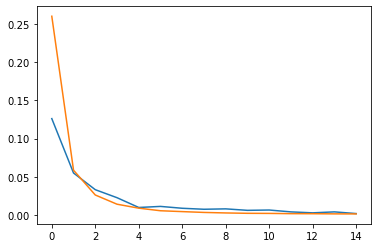

In [26]:
save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/2nd_gen/lstm_nested_cv/")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(cv_fold)]
loss = torch.load(loss_paths[0])
plt.plot(loss["valid"])
plt.plot(loss["train"])

In [27]:
loss

{'train': [0.2599909547465287,
  0.0587380253207669,
  0.02636778531293613,
  0.014318950354137603,
  0.009148004564599879,
  0.005773522714947581,
  0.004648978285081731,
  0.0035717326372119427,
  0.002899539516304275,
  0.0024271780132360567,
  0.0023026488964865612,
  0.0019673858301115722,
  0.0018986245129995309,
  0.0016928086376591476,
  0.0016307452094456404],
 'valid': [0.1261919606899313,
  0.05510136378956411,
  0.03330035214928691,
  0.022833650346786038,
  0.010042277259772699,
  0.011441605346715055,
  0.009012943187068837,
  0.007716186174351891,
  0.008234350842137835,
  0.006305635037885319,
  0.006714706292733157,
  0.004279460249973436,
  0.003039304290010192,
  0.004289030305182107,
  0.0020906578920492427]}

In [11]:
pred

tensor([0.0019, 0.0019, 0.0025,  ..., 0.0022, 0.0015, 0.0020])

In [26]:
true

tensor([0., 0., 0.,  ..., 1., 0., 1.])